# Import Libraries

In [41]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
import os
import time


from tqdm.keras import TqdmCallback
import tqdm 
from tqdm.keras import TqdmCallback 

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16, EfficientNetB3, DenseNet121, MobileNetV2
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# Access the Data

In [46]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harshit991339/plant-disease-datasets")

print("Path to dataset files:", path)

ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/home/harshit/Desktop/CropLens/.venv/lib64/python3.10/site-packages/google/protobuf/internal/__init__.py)

In [ ]:
import os
import shutil

# 1. (You already did this) Extracted path
extracted_path = path

# 2. Desired path
desired_path = "/home/harshit/Desktop/CropLens/data/Image_Data_base/"
os.makedirs(desired_path, exist_ok=True)

# 3. Move the data
for item in os.listdir(extracted_path):
    s = os.path.join(extracted_path, item)
    d = os.path.join(desired_path, item)
    shutil.move(s, d)

# 4. Verify
print(os.listdir(desired_path))

In [ ]:
import zipfile

def unzip_file(zip_path, extract_to):
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)  

        print(f"Successfully extracted {zip_path} to {extract_to}")
    except FileNotFoundError:
        print(f"Error: Zip file not found: {zip_path}")
    except zipfile.BadZipFile:
        print(f"Error: Invalid zip file: {zip_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


# Example usage:
zip_file_path = '/home/harshit/Desktop/CropLens/data/Image_Data_base.zip'  
extraction_directory = '/home/harshit/Desktop/CropLens/data/'  

unzip_file(zip_file_path, extraction_directory)

Successfully extracted /home/harshit/Desktop/CropLens/data/Image_Data_base.zip to /home/harshit/Desktop/CropLens/data/


# Data Observation and EDA to extract vauable for training

In [8]:
dataset_path = "/home/harshit/Desktop/CropLens/data/Image Data base"
directory = dataset_path

In [9]:
total_number = 0
total_classes = 0
name_classes = []
len_classes = []
EPOCHS=2

In [10]:
for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        len_classes.append(num_files)
        name_classes.append(folder)
        total_number += num_files
        total_classes += 1


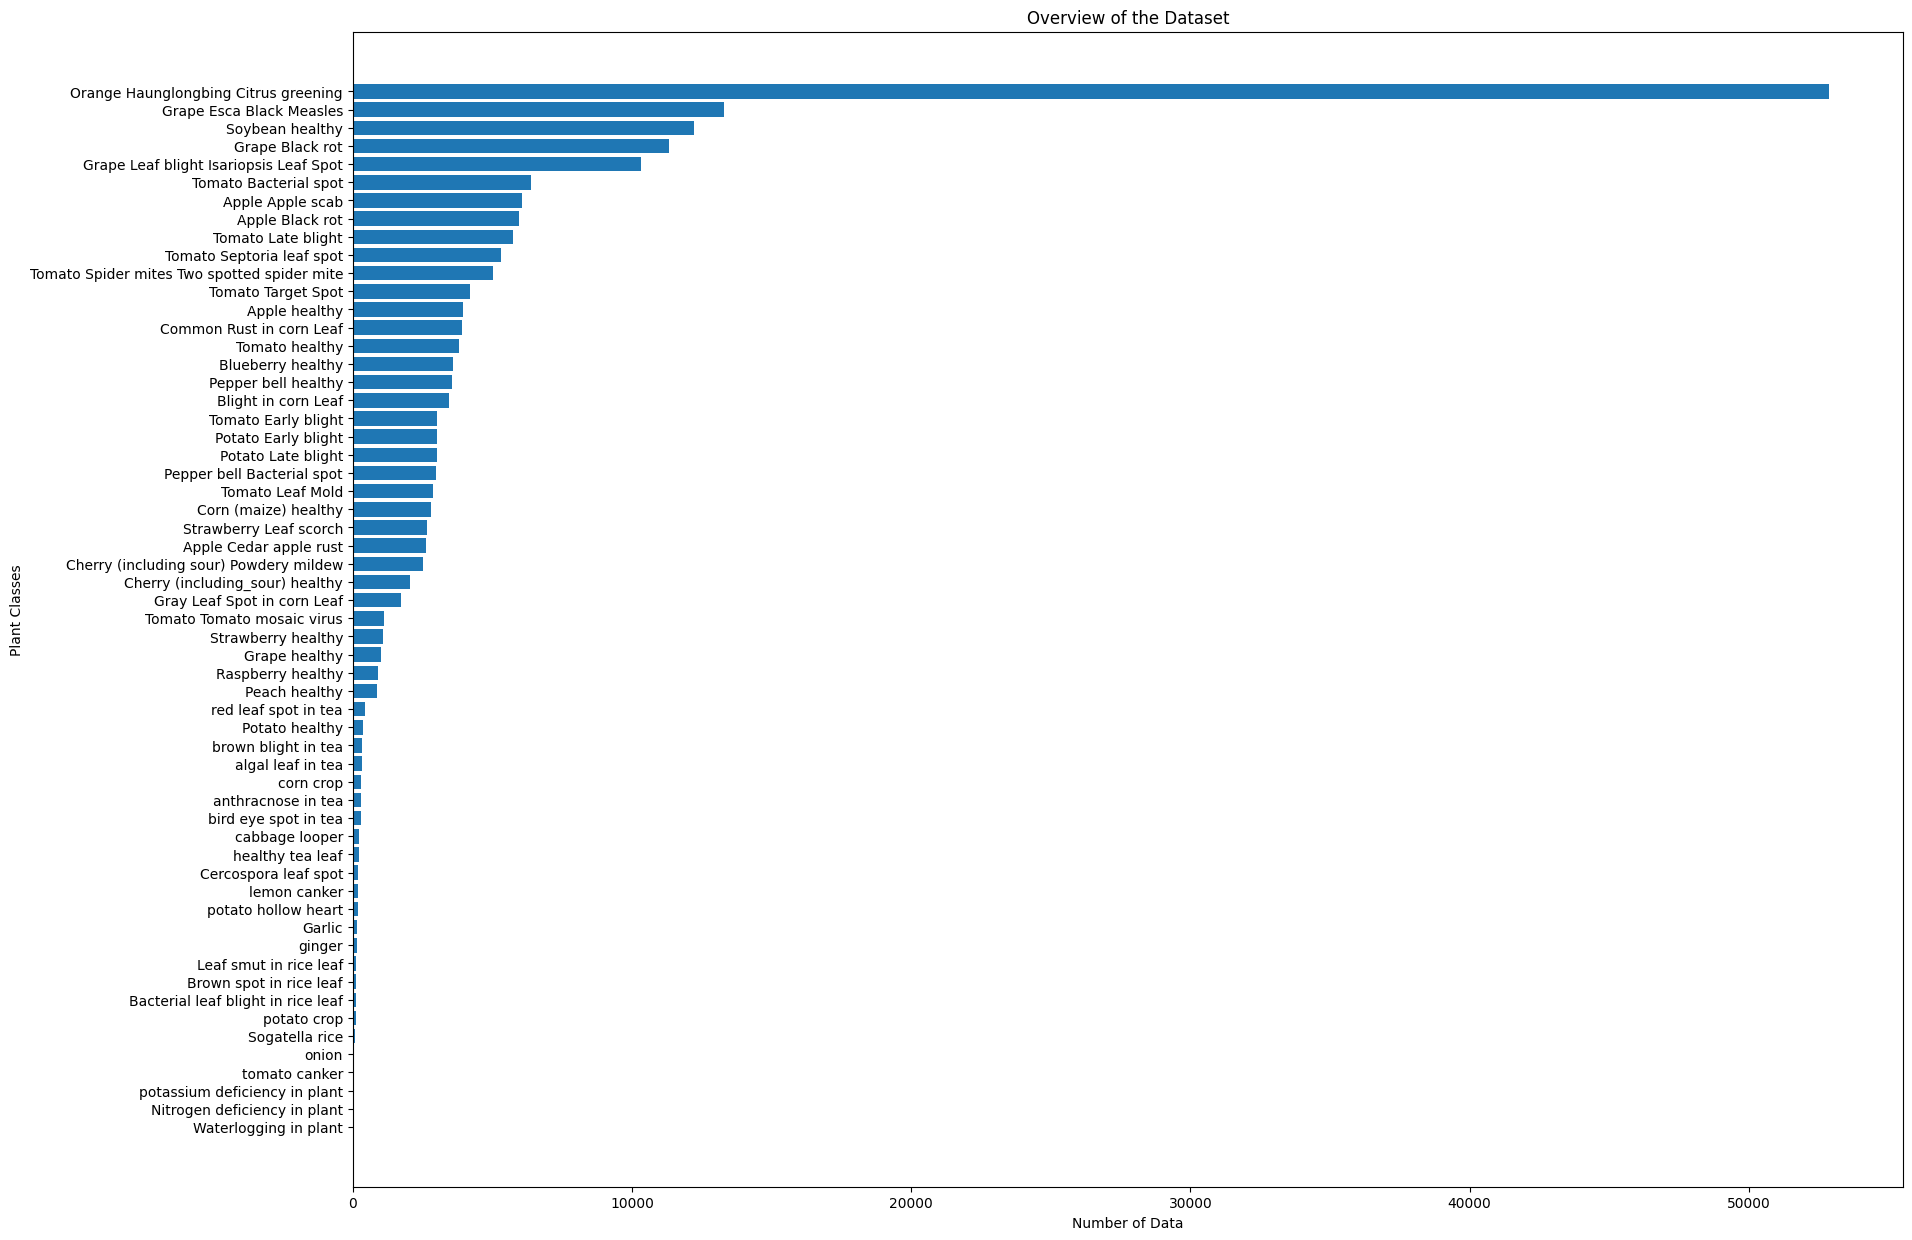

#############################################################################
                      Plant Class  Number of Images
42          Waterlogging in plant                21
20   Nitrogen deficiency in plant                33
53  potassium deficiency in plant                54
57                  tomato canker                57
52                          onion                60


In [11]:
data = {'Plant Class': name_classes, 'Number of Images': len_classes}

df = pd.DataFrame(data)
df_sorted = df.sort_values('Number of Images')

plt.figure(figsize=(20, 15))
plt.barh(df_sorted['Plant Class'], df_sorted['Number of Images'])
plt.title('Overview of the Dataset')
plt.xlabel('Number of Data')
plt.ylabel('Plant Classes')
plt.show()
print("#############################################################################")
min_classes = df_sorted.head(5)
print(min_classes[['Plant Class', 'Number of Images']])

In [12]:
sdir=(dataset_path)
min_samples=40 
filepaths = []
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)
    if len(flist) >= min_samples:
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    else:
        print('class ', klass, ' has only', len(flist), ' samples and will not be included in dataframe')

class  Nitrogen deficiency in plant  has only 33  samples and will not be included in dataframe
class  Waterlogging in plant  has only 21  samples and will not be included in dataframe


In [13]:
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')

df=pd.concat([Fseries, Lseries], axis=1)

train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])

print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))


train_df lenght:  179649   test_df length:  9981   valid_df length:  9981


In [14]:
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))

The number of classes in the dataset is:  56
            CLASS               IMAGE COUNT 


In [15]:
countlist=[]
classlist=[]

In [16]:
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

       Apple Apple scab            5443     
       Apple Black rot             5368     
    Apple Cedar apple rust         2376     
        Apple healthy              3553     
Bacterial leaf blight in rice leaf      108     
     Blight in corn Leaf           3094     
      Blueberry healthy            3245     
   Brown spot in rice leaf          108     
     Cercospora leaf spot           170     
Cherry (including sour) Powdery mildew     2273     
Cherry (including_sour) healthy     1847     
   Common Rust in corn Leaf        3526     
     Corn (maize) healthy          2511     
            Garlic                  132     
       Grape Black rot             10195    
   Grape Esca Black Measles        11956    
Grape Leaf blight Isariopsis Leaf Spot     9299     
        Grape healthy               915     
 Gray Leaf Spot in corn Leaf       1550     
    Leaf smut in rice leaf          108     
Orange Haunglongbing Citrus greening     47585    
        Peach healthy       

In [17]:
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)


Orange Haunglongbing Citrus greening  has the most images=  47585   potassium deficiency in plant  has the least images=  49


In [18]:
ht=0
wt=0

In [19]:
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)


average height=  261  average width=  264 aspect ratio=  0.9876934692336731


In [20]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

In [21]:
max_samples= 198855 
min_samples=36
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)


after trimming, the maximum samples in any class is now  198855  and the minimum samples in any class is  36


In [22]:
batch_size=20 

trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )

In [23]:
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(224, 224),
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 179649 validated image filenames belonging to 56 classes.        for train generator 


In [24]:
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size= (224, 224),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 9981 validated image filenames belonging to 56 classes.          for valid generator 


In [25]:
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size= (224, 224),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 9981 validated image filenames belonging to 56 classes.          for test generator 


In [27]:
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)


test batch size:  9   test steps:  1109  number of classes :  56


In [28]:

print("Total Train Image:-",len(train_df))
print("Total Validation Image:-",len(valid_df))
print("Total Test Image:-",len(test_df))

Total Train Image:- 179649
Total Validation Image:- 9981
Total Test Image:- 9981


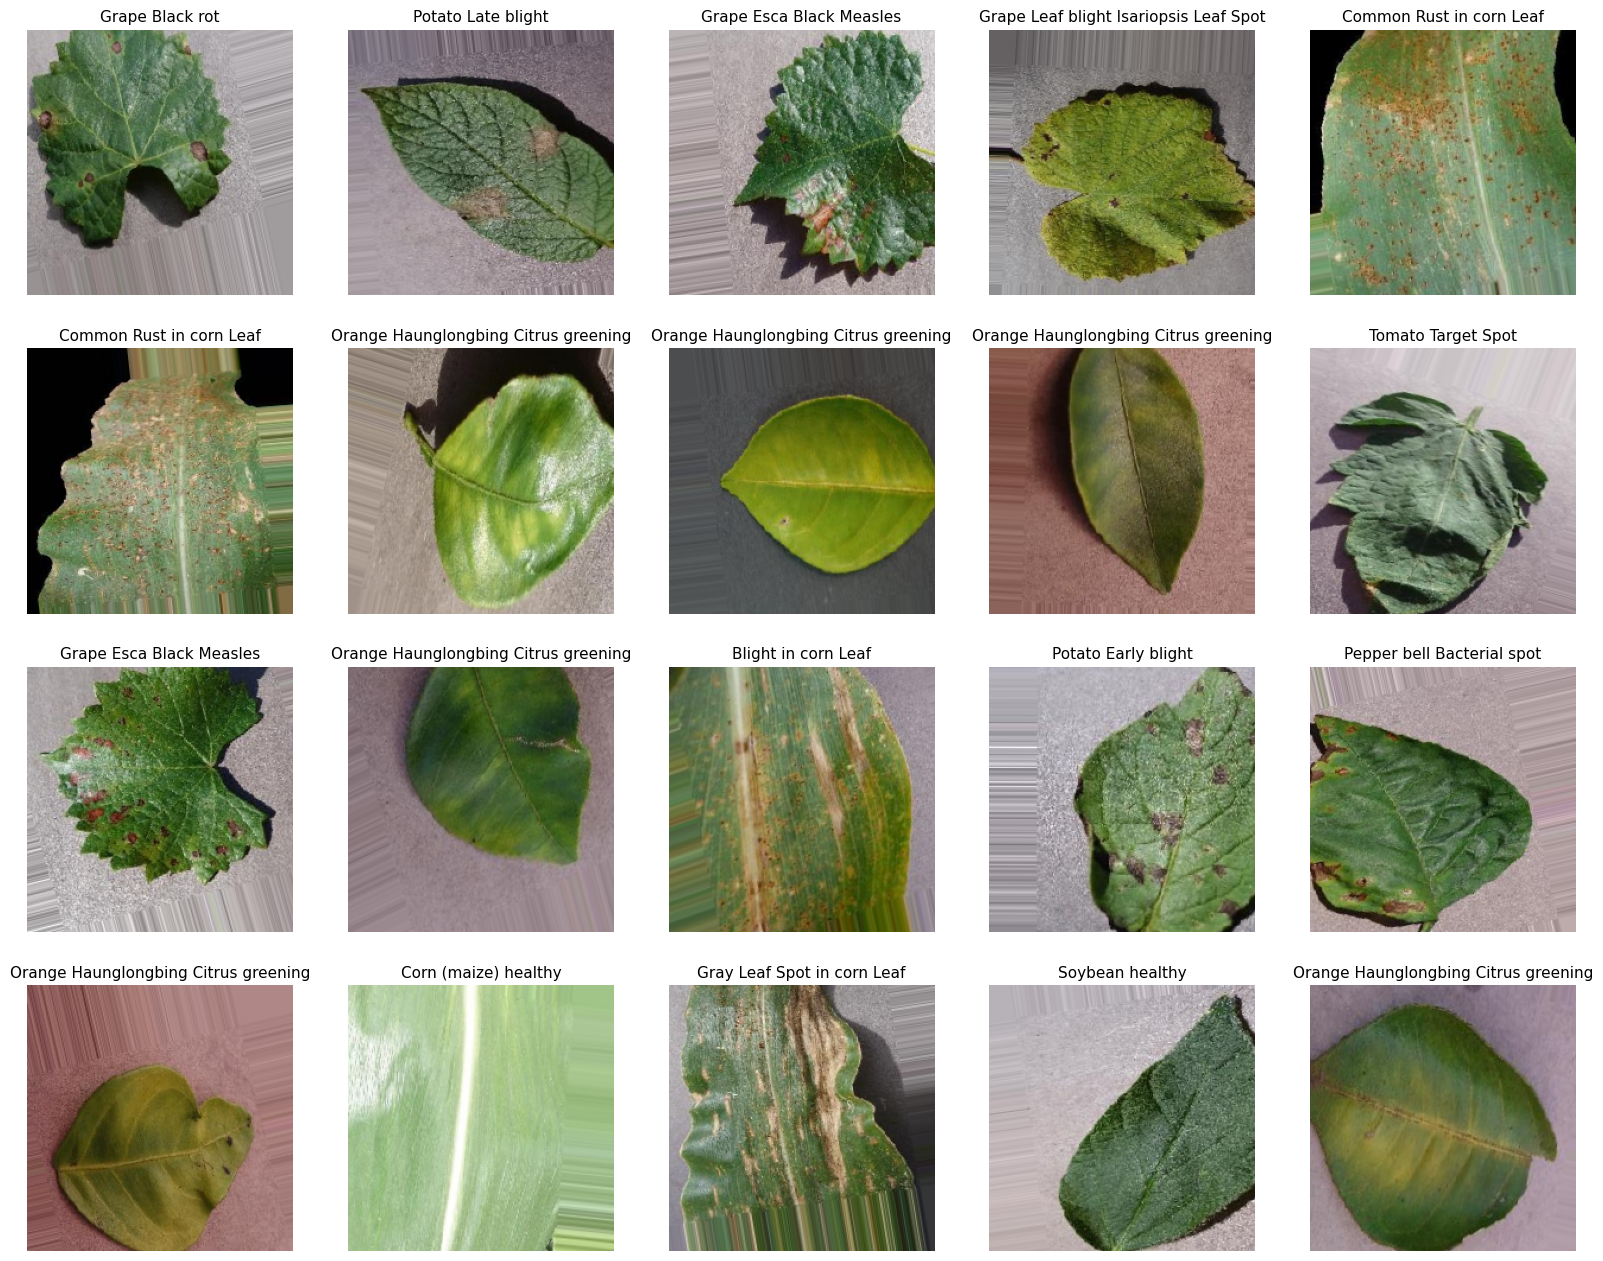

In [29]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='black', fontsize=11)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

In [30]:

num_classes = len(train_df['labels'].unique())

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])


# Model Setup for training

In [31]:
def create_model(base_model):
    base_model.trainable = False  

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [32]:
models = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'EfficientNetB3': EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

2025-02-13 18:15:22.373005: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/harshit/Desktop/CropLens/.venv/lib/python3.10/site-packages/cv2/../../lib64:
2025-02-13 18:15:22.373194: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-13 18:15:22.373343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2025-02-13 18:15:22.374467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appr

In [33]:
model_dict = {}

# Function to do Operation for trim the data and lot the observation

In [34]:

def tr_plot(tr_data, start_epoch, model_name):
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = list(range(start_epoch + 1, Epoch_count + 1))

    index_loss = np.argmin(vloss)  
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)  
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')
    sc_label = f'Best Epoch (Loss) = {index_loss + 1 + start_epoch}'
    vc_label = f'Best Epoch (Accuracy) = {index_acc + 1 + start_epoch}'

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    fig.suptitle(f'{model_name} Training and Validation Metrics')

    axes[0].plot(Epochs, tloss, 'r', label='Training Loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation Loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


In [35]:
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

In [36]:

def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'plots/{prefix}{model_name}_confusion_matrix.png')
    plt.close()

In [37]:
def plot_classification_report(cr, model_name):
    cr_df = pd.DataFrame(cr).transpose()
    cr_df.drop(columns=["support"], inplace=True)  
    cr_df.plot(kind='bar', figsize=(15, 7), colormap='viridis', ylim=(0, 1.1))
    plt.title(f'Classification Report - {model_name}')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.savefig(f'plots/{prefix}{model_name}_classification_report.png')
    plt.close()


In [38]:
confusion_matrices_df = pd.DataFrame()

# To start of the training of Model 

In [39]:

for model_name, base_model in models.items():
    print(f"Building and compiling {model_name}...")
    model = create_model(base_model)
    model_dict[model_name] = model

    print(f"Training {model_name}...")
    start_train_time = time.time()
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=test_gen,
        callbacks=[TqdmCallback(tqdm_class=tqdm.auto.tqdm)]  
    )
    end_train_time = time.time()
    training_time = end_train_time - start_train_time



    tr_plot(history, start_epoch=0, model_name=model_name)

  
    model.save(f'/home/harshit/Desktop/CropLens/models/{prefix}{model_name}_model.h5')

    
    print(f"Evaluating {model_name}...")
    test_results = model.evaluate(test_gen)
    test_loss = test_results[0]
    test_accuracy = test_results[1]


    print(f"Generating predictions for {model_name}...")
    start_pred_time = time.time()
    predictions = model.predict(test_gen)  
    end_pred_time = time.time()

    prediction_time = end_pred_time - start_pred_time

    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_gen.classes


    assert len(predicted_labels) == len(true_labels), "Mismatch in the number of true and predicted labels."

    cm = confusion_matrix(true_labels, predicted_labels)
    plot_confusion_matrix(cm, list(test_gen.class_indices.keys()), model_name)

    cr = classification_report(true_labels, predicted_labels, target_names=test_gen.class_indices.keys(), output_dict=True)
    plot_classification_report(cr, model_name)

    cr_df = pd.DataFrame(cr).transpose()
    cr_df.to_csv(f'models/{prefix}{model_name}_classification_report.csv', index=True)


    cm_df = pd.DataFrame(cm, index=test_gen.class_indices.keys(), columns=test_gen.class_indices.keys())
    cm_df['Training Time (s)'] = training_time
    cm_df['Prediction Time (s)'] = prediction_time
    cm_df['Test Loss'] = test_loss
    cm_df['Test Accuracy'] = test_accuracy


    confusion_matrices_df = pd.concat([confusion_matrices_df, cm_df], axis=1)


Building and compiling ResNet50...
Training ResNet50...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/2


KeyboardInterrupt: 

In [ ]:

confusion_matrices_df.to_csv(f'models/{prefix}confusion_matrices_with_timing.csv', index=True)
print(f"Confusion matrices with timing information and classification reports saved to the 'models' folder with prefix '{prefix}'.")


print("\nTiming Information:")
print(confusion_matrices_df[['Training Time (s)', 'Prediction Time (s)', 'Test Loss', 'Test Accuracy']])



In [ ]:

confusion_matrices_df.to_csv(f'models/{prefix}confusion_matrices_with_timing.csv', index=True)
print(f"Confusion matrices with timing information and classification reports saved to the 'models' folder with prefix '{prefix}'.")


print("\nTiming Information:")
print(confusion_matrices_df[['Training Time (s)', 'Prediction Time (s)', 'Test Loss', 'Test Accuracy']])


# Optimize.DEFAULT Quantization

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(Model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tf_lite_Optimize_DEFAULT_model = converter.convert()
print("Optimize.DEFAULT Quantization:- ",len(tf_lite_Optimize_DEFAULT_model))

In [ ]:
with open("tf_lite_Optimize_DEFAULT_model.tflite", "wb") as f:
    f.write(tf_lite_Optimize_DEFAULT_model)
